In [ ]:
import os
from tqdm import tqdm

from sage.config.config import DataArguments, TrainingArguments, MiscArguments

from sage.config import get_logger, logger_conf
from sage.data import get_dataloader
from sage.utils import seed_everything

from nilearn import plotting
from nilearn.datasets import load_mni152_brain_mask
import nibabel
import numpy as np
import pickle

from sage.legacy.miccai_analysis import *
from sage.legacy.resnet import *
from sage.xai.utils import _mni, load_mni152_template, z_norm, _z_norm, average, _nifti

import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
from tqdm import tqdm
import torch
from captum.attr import LayerGradCam, LayerAttribution

from einops import rearrange
from sklearn.preprocessing import StandardScaler

AVG = np.load("./data/average.npy")

In [ ]:
base_path = "/Volumes/WD_BLACK/May 12 2022 Backup/3DCNN_sMRI"

get_path = lambda f: os.path.join(base_path, f)

In [ ]:
with open(get_path("./data/naive_reg_test_100.pkl"), "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open(get_path("./data/augment_reg_test_100.pkl"), "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [ ]:
with open(get_path("./data/naive_nonreg_test_100.pkl"), "rb") as f:
    naive_nonreg_results = pickle.load(f)
    naive_nonreg_results = {e[0]: e[1] for e in sorted(naive_nonreg_results.items(), key=lambda x: x[0])}
    
with open(get_path("./data/augment_nonreg_test_100.pkl"), "rb") as f:
    augment_nonreg_results = pickle.load(f)
    augment_nonreg_results = {e[0]: e[1] for e in sorted(augment_nonreg_results.items(), key=lambda x: x[0])}

In [ ]:
naive = Result(naive_results)
augment = Result(augment_results)

naive_nonreg = Result(naive_nonreg_results)
augment_nonreg = Result(augment_nonreg_results)

In [ ]:
def first_reached_indices(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    indices = [find_first_reached(ckpts, point) for ckpts in raw_data[config]]
    return [_[0] for _ in indices], mean(list(filter(lambda x: x[1] != -1, indices)))

def first_reached_maes(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    maes = [find_first_reached(ckpts, point)[1] for ckpts in raw_data[config]]
    return list(filter(lambda x: x != -1, maes)), mean(list(filter(lambda x: x != -1, maes)))

In [230]:
from glob import glob

ckpt_path = "/Volumes/WD_BLACK/May 12 2022 Backup/checkpoints(MICCAI2022)"
seeds = sorted(glob(ckpt_path + "/resnet256_augmentation_checkpoints/*"))
ckpts = sorted(glob(seeds[0] + "/*"))

from pathlib import Path

Path(seeds[0])

PosixPath('/Volumes/WD_BLACK/May 12 2022 Backup/checkpoints(MICCAI2022)/resnet256_augmentation_checkpoints/20211001-1526_resnet')

In [ ]:
def load_model_ckpts(path: Path, epoch: int):

    path = Path(path) if isinstance(path, str) else path

    epoch = str(epoch).zfill(3)
    ckpts = dict()
    for model_name in ("encoder", "regressor"):

        ckpt = list(path.glob(f"./{model_name}/ep{epoch}*.pt"))
        assert len(ckpt) == 1
        ckpts[model_name] = ckpt[0]

    mae = float(str(ckpt[0]).split("mae")[-1].split(".pt")[0])

    return ckpts, mae

In [ ]:
load_model_ckpts(seeds[0], 0)

resnet = load_resnet()
regressor = load_predictors["nkregressor"]()
model = Assembled(resnet, regressor)

In [ ]:
ckpt_dict, mae = load_model_ckpts(seeds[0], 0)
model.load_weight(ckpt_dict)

In [ ]:
data_args, training_args, misc_args = (
    DataArguments(),
    TrainingArguments(),
    MiscArguments(),
)
seed_everything(misc_args.seed)
misc_args.output_dir = "./"
# data_args.batch_size = 1

logger_conf["handlers"]["file_handler"]["filename"] = misc_args.output_dir + "/run.log"
logger = get_logger(logger_conf)

test_dataloader = get_dataloader(data_args, misc_args, "test", logger)

## Without Pre-registration

In [ ]:
# ALL
for path, ckpt_idx in zip(seeds, first_reached_indices("naive", 7.27)[0]):

    model = Assembled(resnet, regressor)
    conv_layers = model.conv_layers()
    ckpt_dict, mae = load_model_ckpts(path, ckpt_idx)
    model.load_weight(ckpt_dict)

    layer_and_map = {}
    for layer_idx, conv_layer in enumerate(tqdm(conv_layers)):

        # logger.info(f"Layer {layer_idx}: {conv_layer}")
        layer_gc = LayerGradCam(model, conv_layer)

        saliency_map = []
        maps = None
        for x, y in tqdm(test_dataloader):

            # x, y = map(lambda x: x.to("cuda"), (x, y))
            attr = layer_gc.attribute(x)
            upsampled_attr = (
                LayerAttribution.interpolate(
                    attr, (96, 96, 96), interpolate_mode="trilinear"
                )
                .cpu()
                .detach()
            )
            z_normed = z_norm(upsampled_attr)
            saliency_map.append(upsampled_attr)
            maps = torch.cat((maps, z_normed), dim=0) if maps is not None else z_normed

        layer_and_map[layer_idx] = maps

    break

In [ ]:
cut_coords = (48, 48, 48)

In [ ]:
for layer_idx, saliency_map in layer_and_map.items():

    avg_map = average(saliency_map, 0).squeeze()
    null_val = torch.mode(avg_map.flatten(), 0).values

    # model.stage0.rbr_dense.conv
    display = plotting.plot_anat(_nifti(AVG), cut_coords=cut_coords)
    display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), alpha=.7)

In [ ]:
avg_map = average(layer_and_map[4], 0).squeeze()
null_val = torch.mode(avg_map.flatten(), 0).values

# model.stage0.rbr_dense.conv
display = plotting.plot_anat(_nifti(AVG), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), alpha=.7, threshold=.6)

In [ ]:
avg_map = average(layer_and_map[5], 0).squeeze()
null_val = torch.mode(avg_map.flatten(), 0).values

# model.stage0.rbr_dense.conv
display = plotting.plot_anat(_nifti(AVG), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), alpha=.7, threshold=.2)

## With pre-registration

In [ ]:
pre_registered = glob("../pre-registered/*.pkl")

In [ ]:
def pkl2npy(s, prefix="/Users/daehyuncho/codespace/brainmask_mni/", extension="npy"):

    s = "-".join(s.split("/")[-1].split("-")[1:])[:-4]

    prefix += s + f".{extension}"
    return prefix

In [ ]:
def first_reached(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    indices = [find_first_reached(ckpts, point) for ckpts in raw_data[config]]
    return [r[0] if r[1] != -1 else -1 for r in indices]
    # return [_[0] for _ in indices], mean(list(filter(lambda x: x[1] != -1, indices)))

In [290]:
target_layer_idx = -3
mni_shape = (99, 117, 95)

test_dataset = test_dataloader.dataset
test_filelist = test_dataloader.dataset.data_files

ckpt_saliencies = {}
threshold_mae = 5.4
ckpt_indices = first_reached("augment", threshold_mae)
num_valids = len(list(filter(lambda x: x != -1, ckpt_indices)))
print(num_valids)

26


(array([ 1., nan]), array([220050, 880335]))
(array([0., 1.]), array([865010, 235375]))


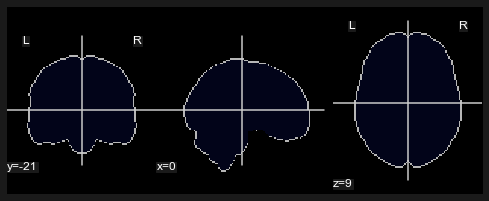

In [291]:
mask = load_mni152_brain_mask().get_fdata()

_int = 1
s = tuple([shape + _int * 2 for shape in mni_shape])
smaller_mask = np.zeros(s)

smaller_mask[_int:s[0]-_int, _int:s[1]-_int, _int:s[2]-_int] = mask
# smaller_mask[np.where(smaller_mask != 0.)] = 1
# smaller_mask[np.where(smaller_mask == 0.)] = np.nan
smaller_mask = LayerAttribution.interpolate(torch.tensor(smaller_mask)[None, None, ...], mni_shape, interpolate_mode="trilinear")[0][0].numpy()
smaller_mask[smaller_mask < 0.5] = np.nan
smaller_mask[smaller_mask > 0.5] = 1.

display = plotting.plot_anat(_mni(mask.copy()))
display.add_overlay(_mni(smaller_mask.copy()))

print(np.unique(smaller_mask, return_counts=True))
print(np.unique(mask, return_counts=True))

In [ ]:
X = torch.cat([test_dataset[test_filelist.index(pkl2npy(pkl_fname))][0] for pkl_fname in pre_registered]).unsqueeze(dim=1)

x = X[:16]
attr_batch = layer_gc.attribute(x)
upsampled_attr = (
    LayerAttribution.interpolate(
        attr_batch, (96, 96, 96), interpolate_mode="trilinear"
    )
    .cpu()
    .detach()
)

saliency_map = rearrange(
    upsampled_attr, "b c h w d -> b (c h w d)"
).numpy()
# num_test = saliency_map.shape[0]

scaler = StandardScaler()
saliency_std = rearrange(
    scaler.fit_transform(saliency_map.T),
    "(h w d) b -> d w h b",
    h=96,
    w=96,
    d=96,
).T

saliency_batch = saliency_std.sum(axis=0)

In [293]:
for path, ckpt_idx in zip(seeds, ckpt_indices):

    if ckpt_idx == -1:
        continue

    model = Assembled(resnet, regressor)
    conv_layers = model.conv_layers()
    ckpt_dict, mae = load_model_ckpts(path, ckpt_idx)
    model.load_weight(ckpt_dict)

    conv_layer = model.conv_layers()[target_layer_idx]
    # logger.info(f"Layer {layer_idx}: {conv_layer}")
    layer_gc = LayerGradCam(model, conv_layer)
    saliency_map = []
    for pkl_fname in tqdm(pre_registered):

        npy_fname = pkl2npy(pkl_fname)
        npy_idx = test_filelist.index(npy_fname)
        
        x, y = test_dataset[npy_idx]
        with open(pkl_fname, "rb") as f:
            transform_matrix = pickle.load(f)

        attr = layer_gc.attribute(x[None, ...])
        upsampled_attr = (
            LayerAttribution.interpolate(
                attr, mni_shape, interpolate_mode="trilinear"
            )
            .cpu()
            .detach()
        )
        transformed_attr = transform_matrix["SymmetricDiffeomorphicRegistration"].transform(upsampled_attr[0][0])
        transformed_attr *= smaller_mask
        saliency_map.append(torch.tensor(transformed_attr[None, None, ...]))

    saliency_map = rearrange(
        torch.cat(saliency_map, dim=0), "b c h w d -> b (c h w d)"
    ).numpy()
    num_test = saliency_map.shape[0]

    scaler = StandardScaler()
    saliency_std = rearrange(
        scaler.fit_transform(saliency_map.T),
        "(h w d) b -> d w h b",
        h=mni_shape[0],
        w=mni_shape[1],
        d=mni_shape[2],
    ).T
    saliency_map_avg = saliency_std.sum(axis=0) / num_test
        
    # saliency_map /= len(pre_registered)
    ckpt_saliencies[path] = saliency_map_avg
    # ckpt_saliencies[path] = saliency_map
    break

Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.22it/s]


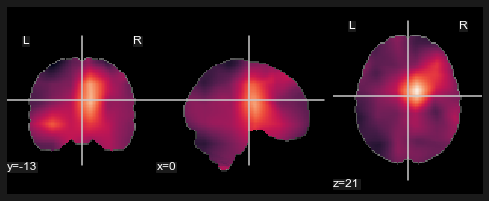

In [294]:
display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(saliency_map_avg))

In [ ]:
server_npy = np.load("/Users/daehyuncho/Downloads/augment_late_server.npy")

In [295]:
total_ckpt_saliencies = {}
for t_mae, true_valids in tqdm(zip([7.27, 6.0, 5.4], [100, 83, 26])):

    ckpt_indices = first_reached("augment", t_mae)
    num_valids = len(list(filter(lambda x: x != -1, ckpt_indices)))
    assert num_valids == true_valids

    ckpt_saliencies = {}
    for path, ckpt_idx in zip(seeds, ckpt_indices):

        if ckpt_idx == -1:
            continue

        model = Assembled(resnet, regressor)
        conv_layers = model.conv_layers()
        ckpt_dict, mae = load_model_ckpts(path, ckpt_idx)
        model.load_weight(ckpt_dict)

        conv_layer = model.conv_layers()[target_layer_idx]
        # logger.info(f"Layer {layer_idx}: {conv_layer}")
        layer_gc = LayerGradCam(model, conv_layer)
        saliency_map = []
        for pkl_fname in tqdm(pre_registered):

            npy_fname = pkl2npy(pkl_fname)
            npy_idx = test_filelist.index(npy_fname)
            
            x, y = test_dataset[npy_idx]
            with open(pkl_fname, "rb") as f:
                transform_matrix = pickle.load(f)

            attr = layer_gc.attribute(x[None, ...])
            upsampled_attr = (
                LayerAttribution.interpolate(
                    attr, mni_shape, interpolate_mode="trilinear"
                )
                .cpu()
                .detach()
            )
            transformed_attr = transform_matrix["SymmetricDiffeomorphicRegistration"].transform(upsampled_attr[0][0])
            transformed_attr *= smaller_mask
            saliency_map.append(torch.tensor(transformed_attr[None, None, ...]))

        saliency_map = rearrange(
            torch.cat(saliency_map, dim=0), "b c h w d -> b (c h w d)"
        ).numpy()
        num_test = saliency_map.shape[0]

        scaler = StandardScaler()
        saliency_std = rearrange(
            scaler.fit_transform(saliency_map.T),
            "(h w d) b -> d w h b",
            h=mni_shape[0],
            w=mni_shape[1],
            d=mni_shape[2],
        ).T
        saliency_map_avg = saliency_std.sum(axis=0) / num_test
            
        # saliency_map /= len(pre_registered)
        ckpt_saliencies[path] = saliency_map_avg
    
    total_ckpt_saliencies[t_mae] = ckpt_saliencies

0it [00:00, ?it/s]

Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  9.05it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.19it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.15it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.19it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.17it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.18it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  8.72it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  8.93it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  9.11it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.20it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:15<00:00,  9.16it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  9.11it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  9.06it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  8.82it/s]


Weights successfully loaded!


100%|██████████| 146/146 [00:16<00:00,  8.81it/s]


Weights successfully loaded!


In [ ]:
# Early, earlylayer - masked
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(_mni(AVG))
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Early, earlylayer - masked
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(_mni(AVG))
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Early, midlayer - masked
total_saliency = sum(total_ckpt_saliencies[6.0].values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Early, latelayer - masked
total_saliency = sum(total_ckpt_saliencies[5.4].values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Early, earlylayer
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Mid, earlylater
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Late, earlylater
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Early
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Mid
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [ ]:
# Late
total_saliency = sum(ckpt_saliencies.values()) / num_valids

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_saliency), alpha=0.7, threshold=0.02)

In [232]:
for key, val in total_ckpt_saliencies.items():
    with open(f"../miccai2022_spm/resnet_lastlayer_smallmask/aug, reg/naive_{key}.pkl", "wb") as f:
        pickle.dump(val, f)

In [ ]:
with open("../miccai2022_spm/resnet_earlylayer/nonsuh, reg/augment_late.pkl", "wb") as f:
    pickle.dump(ckpt_saliencies, f)

# Find Agreement

In [ ]:
np.unique(smaller_mask)

In [ ]:
thresholded, nonzero = exp_quantile_agree(np.array(list(ckpt_saliencies.values())), 0.95, 4)

display = plotting.plot_anat(load_mni152_template(), display_mode="mosaic")
display.add_overlay(_mni(thresholded))

In [ ]:
from skimage.filters import gaussian


mask = load_mni152_brain_mask().get_fdata()
def count_nonzero_voxels(array):

    f = array.flatten()
    return (1 - np.logical_or(np.isnan(f), f == 0)).sum()

def exp_quantile_agree(
    maps_agg, quantile, agree_threshold, masked=False, blur=True
):

    """
    Make hard thresholding map
    """

    print(f"Quantile: {quantile:.2f} | Agree Threhsold: {agree_threshold}")

    if masked:
        maps_agg *= smaller_mask
    bool_brain = np.array(
        [(np.abs(npy) > np.nanquantile(np.abs(npy), quantile)) for npy in maps_agg]
    )  # (N, 96, 96, 96) maps with boolean

    if agree_threshold < 10:
        agreement = bool_brain.sum(axis=0) >= 1
        thresholded = (maps_agg * agreement).sum(axis=0)
        thresholded = np.array(
            [
                (np.abs(npy) > np.nanquantile(np.abs(npy), 0.99)) * npy
                for npy in thresholded
            ]
        )

    else:
        agreement = (
            bool_brain.sum(axis=0) >= agree_threshold
        )  # (96, 96, 96), boolean of agreement
        thresholded = (maps_agg * agreement).sum(
            axis=0
        )  # (96, 96, 96), real voxel values. no normalize

    nonzero_voxels = count_nonzero_voxels(thresholded)
    print(f"Nonzero Voxels: {nonzero_voxels}")

    if blur:
        thresholded = gaussian(thresholded)

    return thresholded, nonzero_voxels

In [ ]:
t, s = exp_quantile_agree(server_npy, quantile=0.9, agree_threshold=13, blur=False)

display = plotting.plot_anat(_mni(AVG), display_mode="mosaic")
display.add_overlay(_mni(t))

In [ ]:
display = plotting.plot_anat(load_mni152_template(), display_mode="mosaic")
display.add_overlay(_mni(sum(ckpt_saliencies.values())), threshold=0.1)

In [ ]:
t, s = exp_quantile_agree(np.array(list(ckpt_saliencies.values())), quantile=0.95, agree_threshold=13, blur=False)

display = plotting.plot_anat(load_mni152_template(), display_mode="mosaic")
display.add_overlay(_mni(t))

In [ ]:
threshold = 0.90
agree_pct = 0.5

In [228]:
def open_and_show(fname, valids, threshold=threshold, agree_pct=agree_pct, template="mni", masked=True):

    with open(fname, "rb") as f:
        arrays = pickle.load(f)

    template = load_mni152_template() if template == "mni" else _mni(AVG)
    
    # Soft
    total_saliency = sum(arrays.values()) / valids
    display = plotting.plot_anat(template)
    display.add_overlay(_mni(total_saliency))

    arrays = np.array(list(arrays.values()))
    thresholded, nonzeros = exp_quantile_agree(arrays, threshold, round(valids * agree_pct), masked=masked, blur=False)

    # Hard
    display = plotting.plot_anat(template, display_mode="mosaic")
    display.add_overlay(_mni(thresholded))
    return thresholded

In [234]:
threshold = 0.80
agree_pct = 0.5

In [ ]:
early_t = open_and_show("../miccai2022_spm/resnet_early_mask_small/aug, reg/naive_7.27.pkl", 100, threshold, agree_pct, masked=False)
mid_t = open_and_show("../miccai2022_spm/resnet_early_mask_small/aug, reg/naive_6.0.pkl", 83, threshold, agree_pct, masked=False)
late_t = open_and_show("../miccai2022_spm/resnet_early_mask_small/aug, reg/naive_5.4.pkl", 26, threshold, agree_pct, masked=False)

In [ ]:
early_t = open_and_show("../miccai2022_spm/resnet_early_mask_small/nonaug, reg/naive_7.27.pkl", 100, threshold, agree_pct, masked=False)
mid_t = open_and_show("../miccai2022_spm/resnet_early_mask_small/nonaug, reg/naive_6.0.pkl", 83, threshold, agree_pct, masked=False)
late_t = open_and_show("../miccai2022_spm/resnet_early_mask_small/nonaug, reg/naive_5.4.pkl", 26, threshold, agree_pct, masked=False)

In [175]:
with open("../miccai2022_spm/resnet_early_proper_smallmask/aug, reg/naive_7.27.pkl", "rb") as f:

    tmp = pickle.load(f)

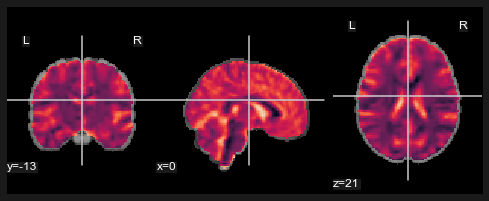

In [176]:
display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(sum(tmp.values())))

In [270]:
threshold = 0.9
agree_pct = 0.5

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 0
Quantile: 0.90 | Agree Threhsold: 42
Nonzero Voxels: 0
Quantile: 0.90 | Agree Threhsold: 13
Nonzero Voxels: 201


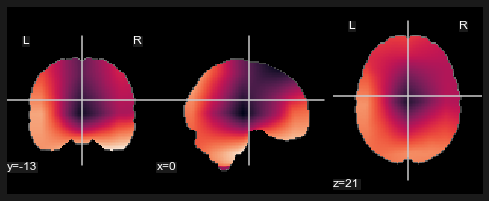

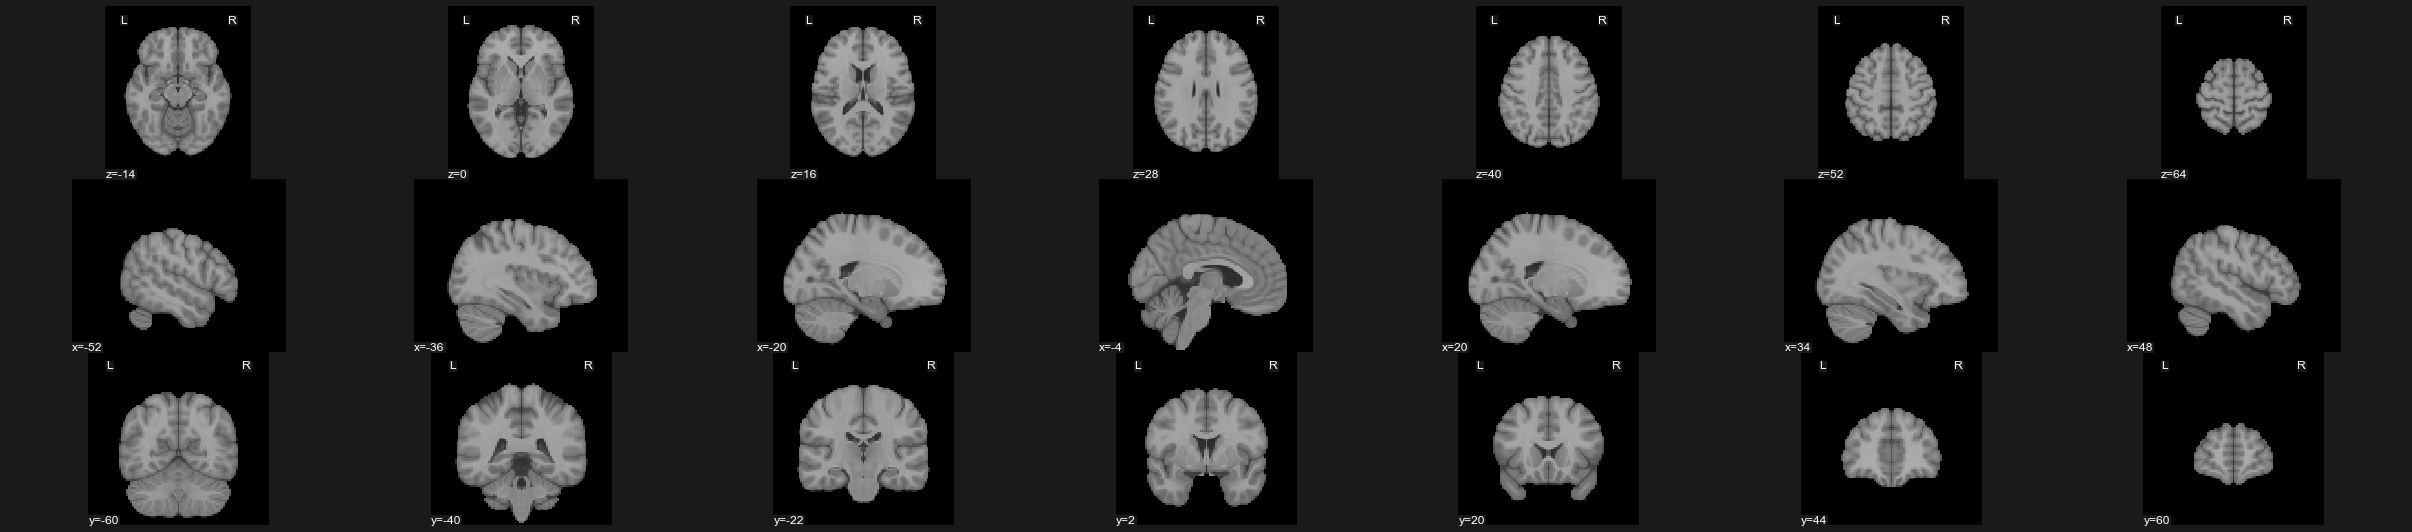

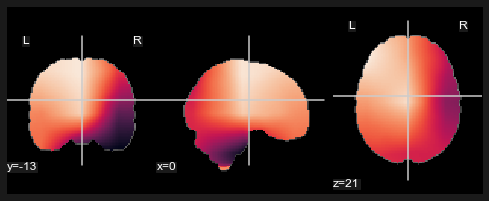

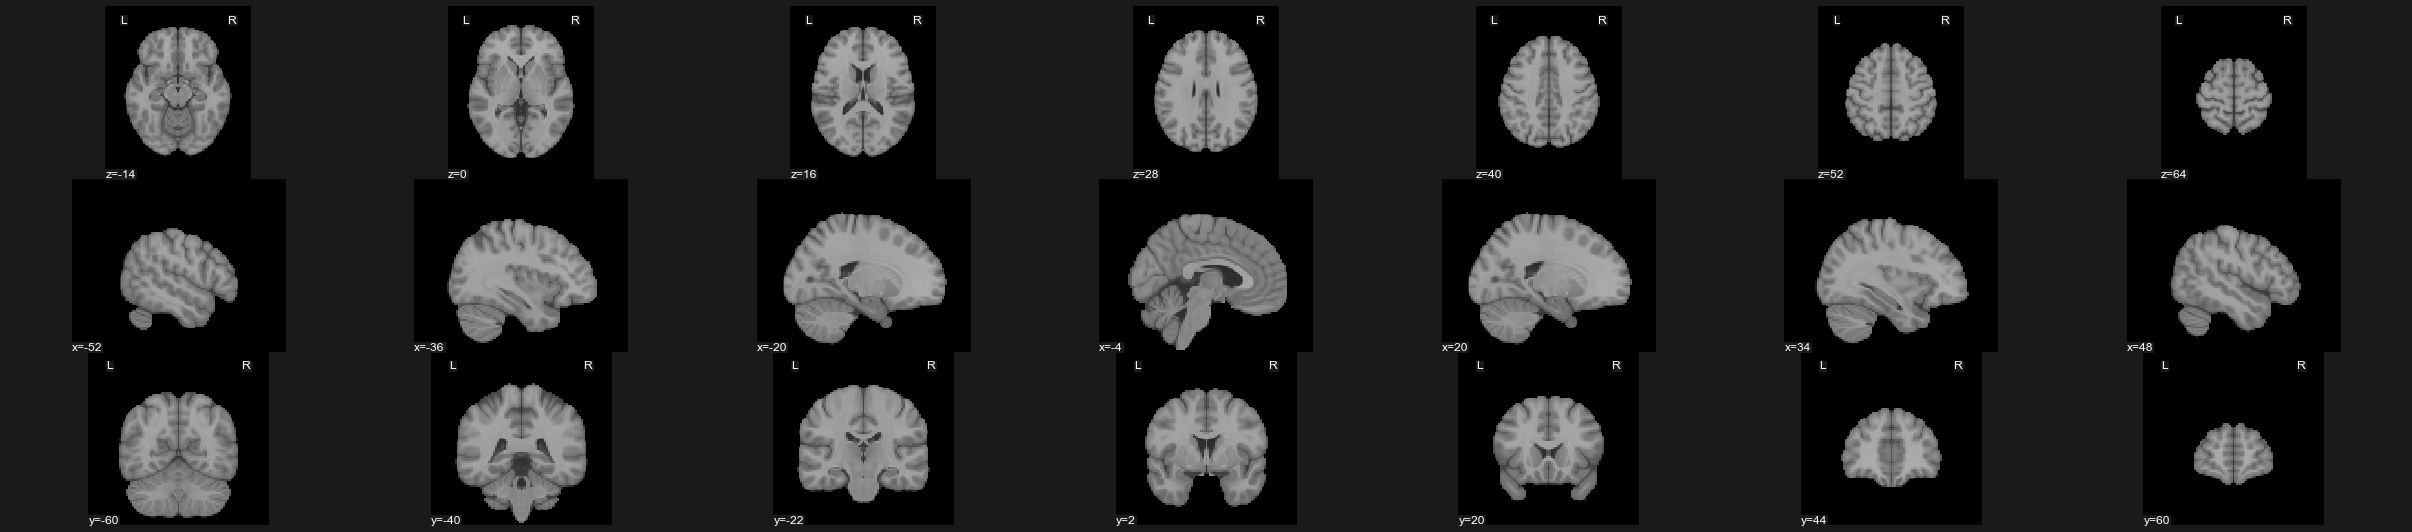

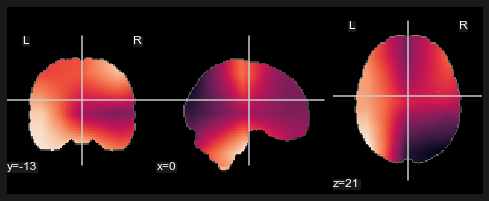

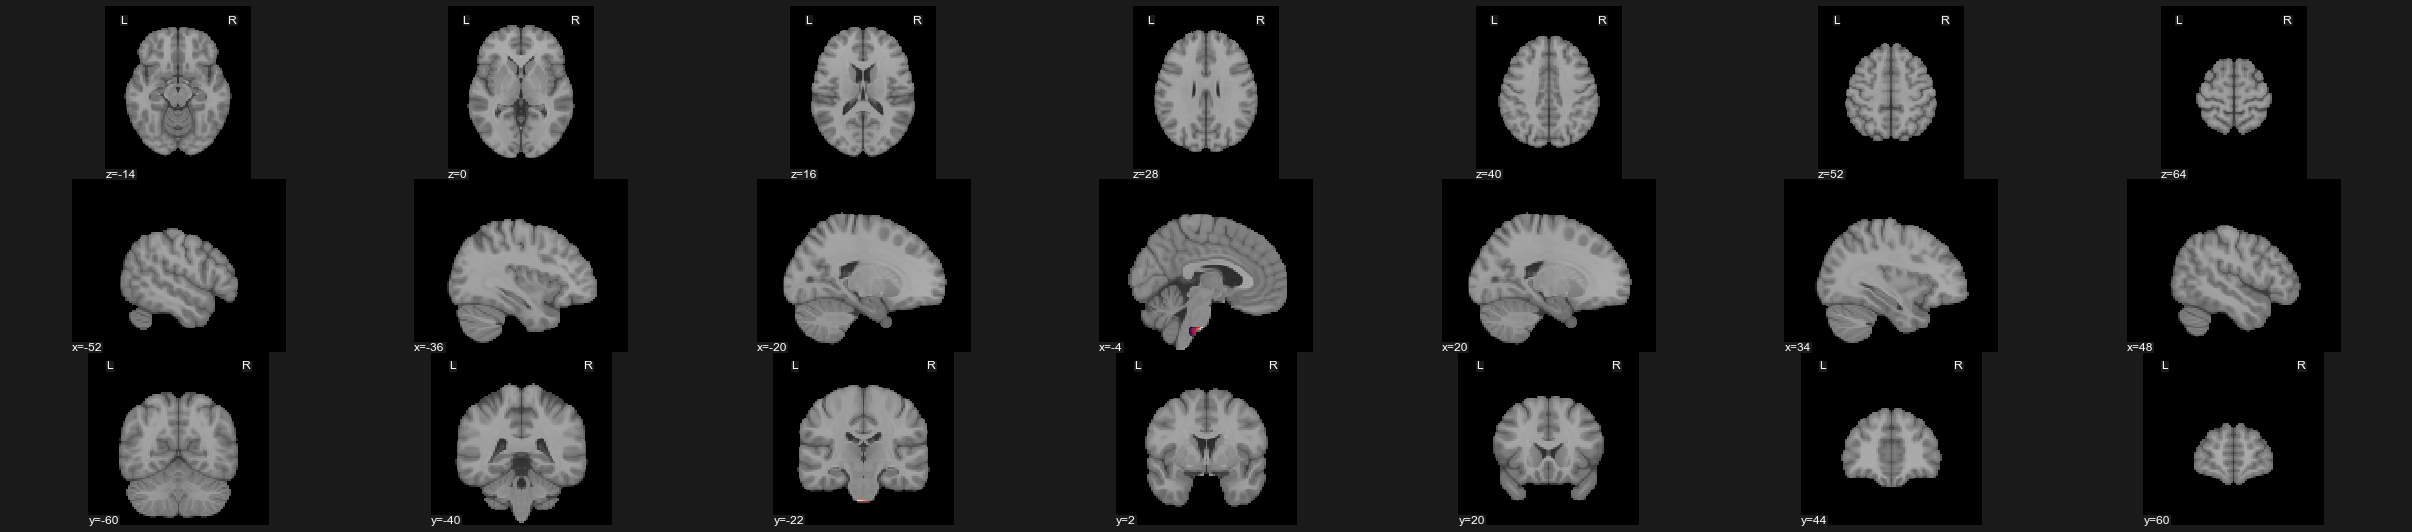

In [271]:
early_t = open_and_show("../miccai2022_spm/resnet_lastlayer_smallmask/aug, reg/naive_7.27.pkl", 100, threshold, agree_pct, masked=False)
mid_t = open_and_show("../miccai2022_spm/resnet_lastlayer_smallmask/aug, reg/naive_6.0.pkl", 83, threshold, agree_pct, masked=False)
late_t = open_and_show("../miccai2022_spm/resnet_lastlayer_smallmask/aug, reg/naive_5.4.pkl", 26, threshold, agree_pct, masked=False)

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 0
Quantile: 0.90 | Agree Threhsold: 26
Nonzero Voxels: 0
Quantile: 0.90 | Agree Threhsold: 4
Nonzero Voxels: 2230


/Users/daehyuncho/anaconda3/envs/research/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


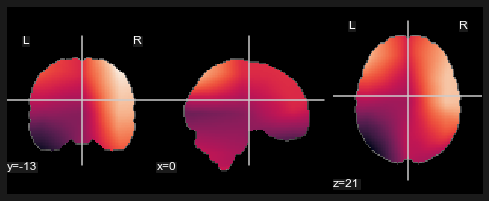

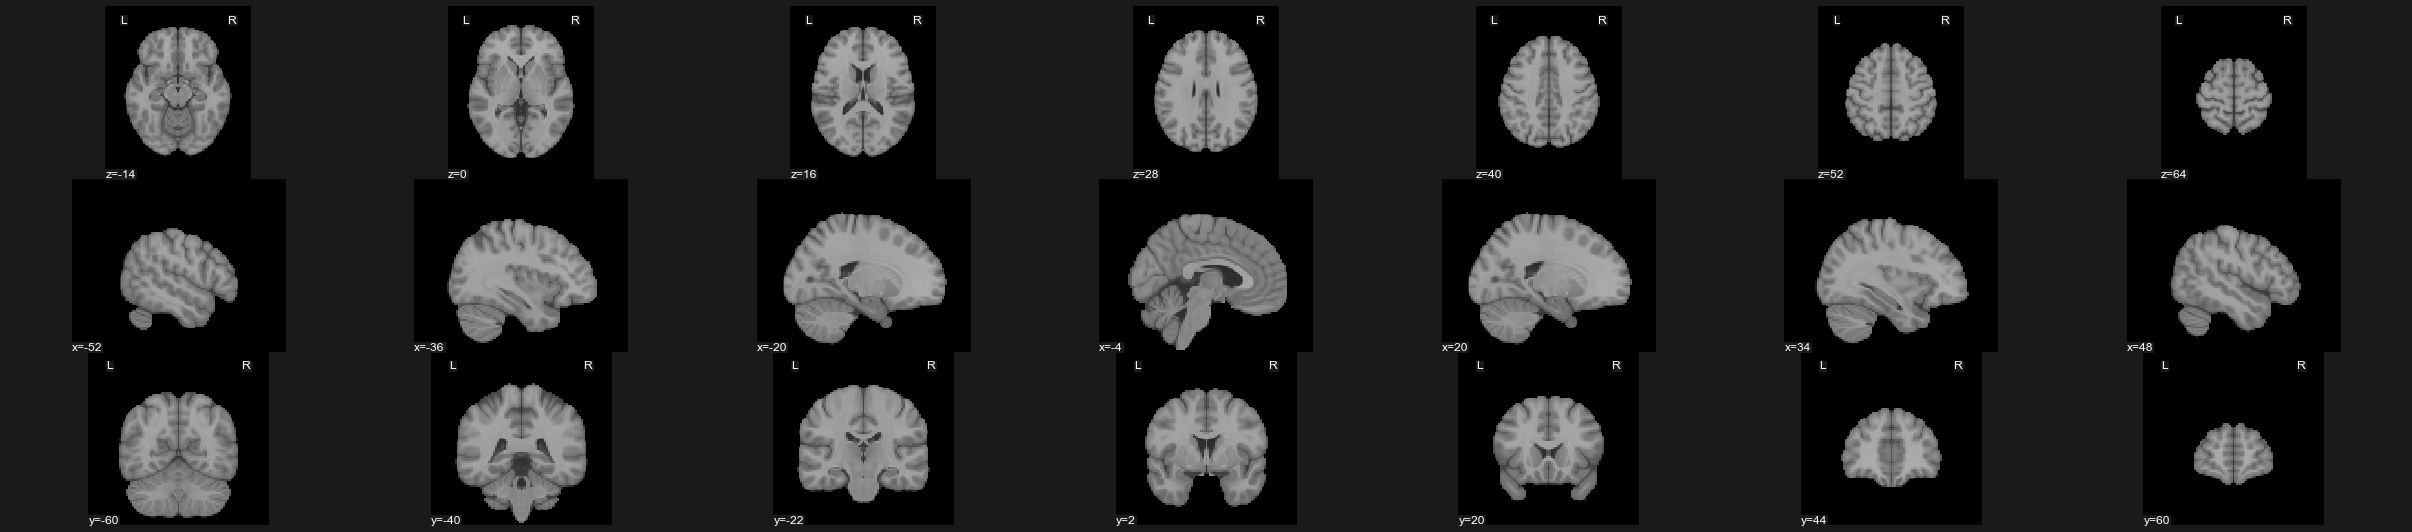

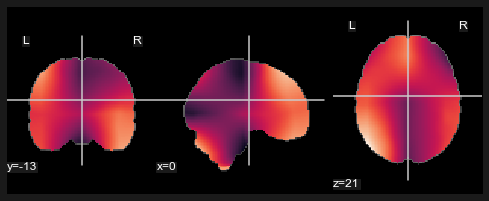

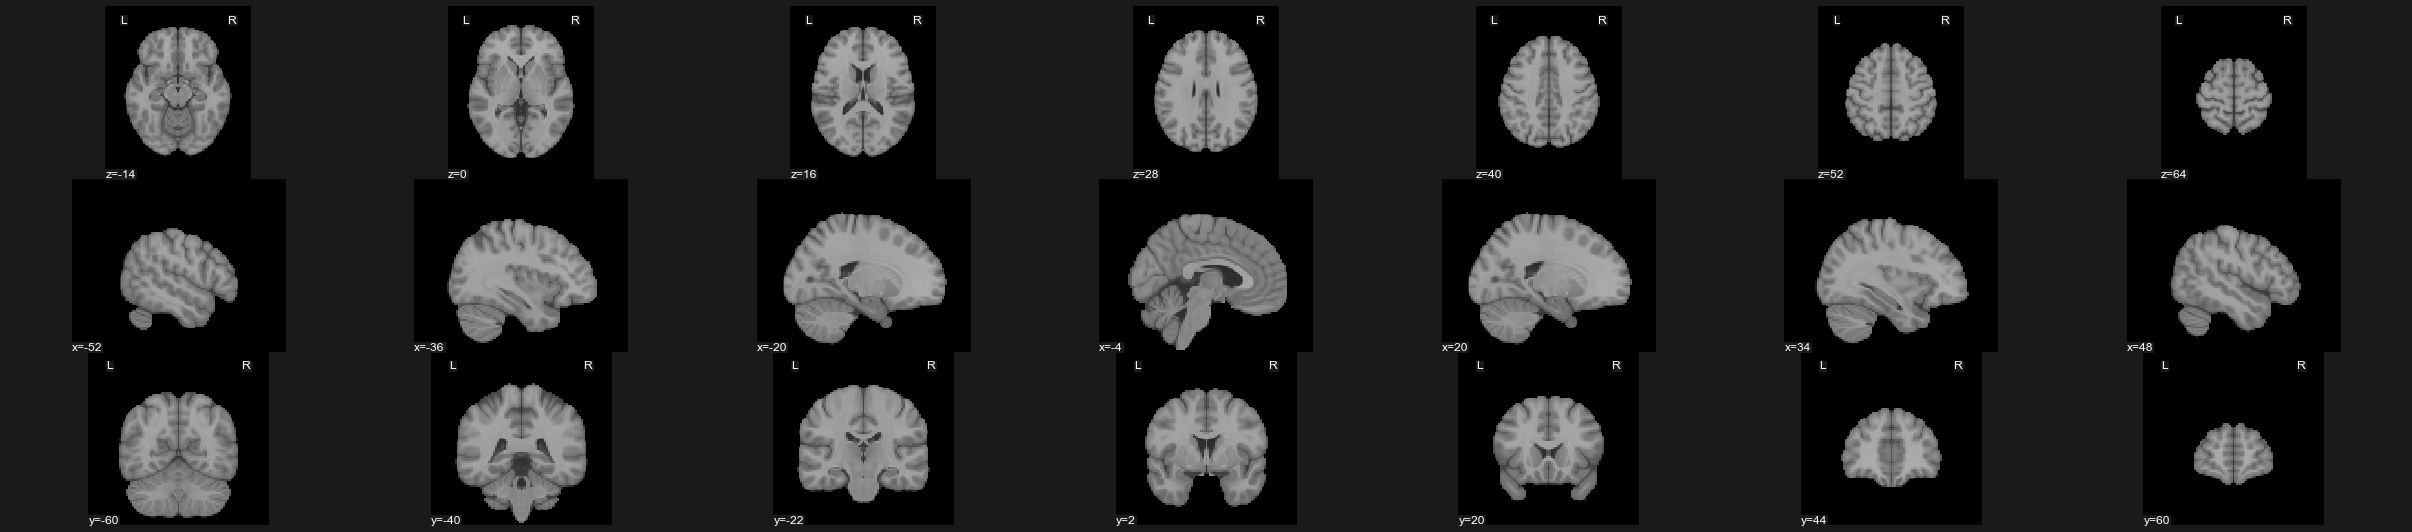

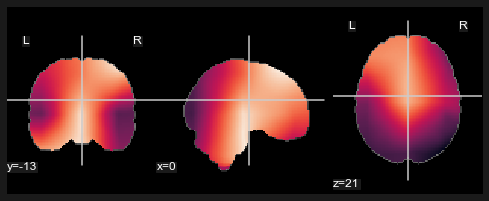

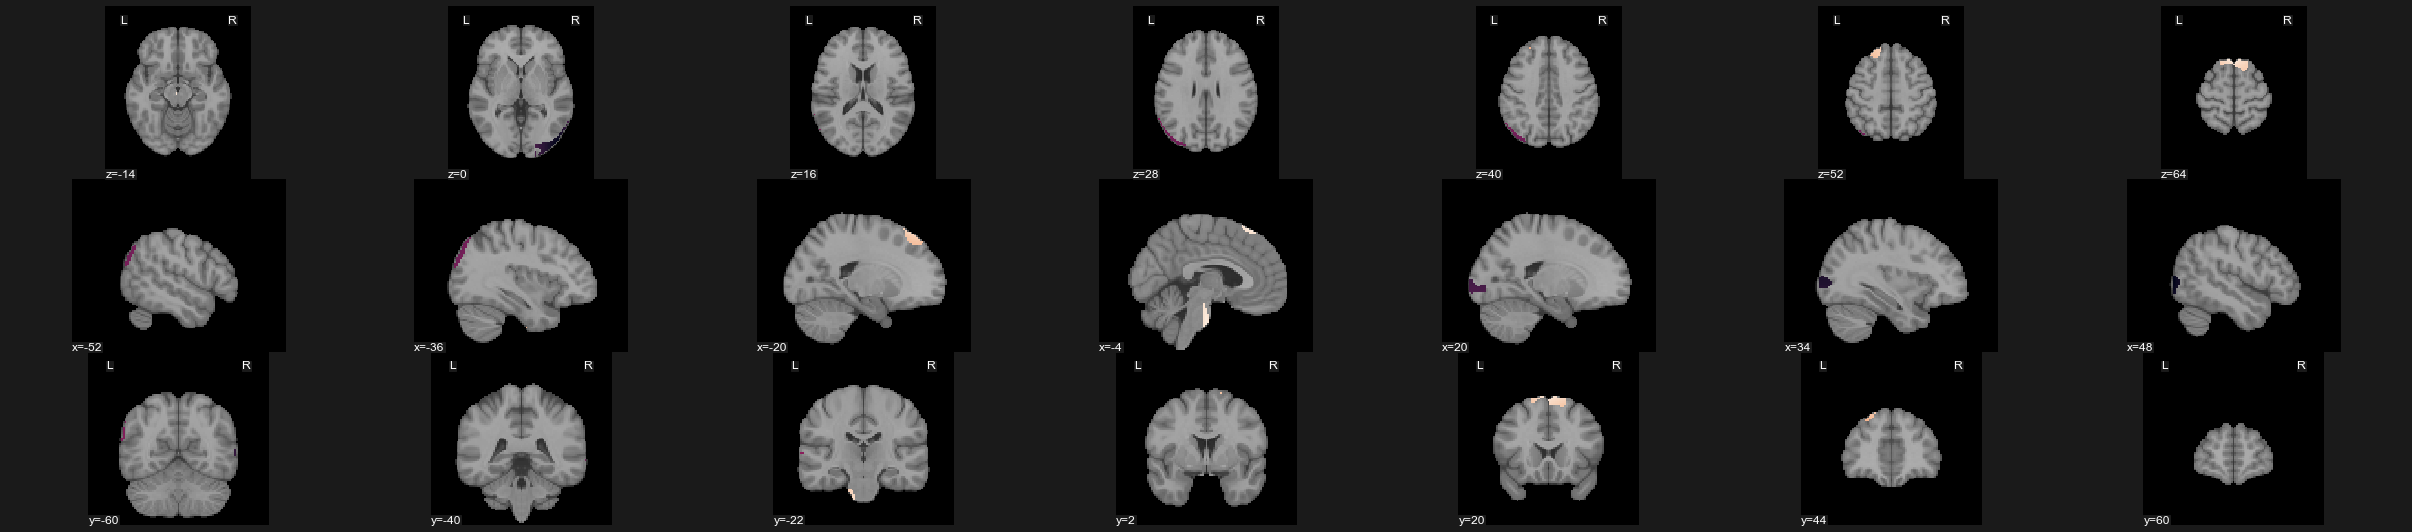

In [229]:
early_t = open_and_show("../miccai2022_spm/resnet_lastlayer_smallmask/nonaug, reg/naive_7.27.pkl", 100, threshold, agree_pct, masked=False)
mid_t = open_and_show("../miccai2022_spm/resnet_lastlayer_smallmask/nonaug, reg/naive_6.0.pkl", 53, threshold, agree_pct, masked=False)
late_t = open_and_show("../miccai2022_spm/resnet_lastlayer_smallmask/nonaug, reg/naive_5.4.pkl", 7, threshold, agree_pct, masked=False)

In [ ]:
def bool_quantile(
    maps_agg, quantile, agree_threshold, masked=False, blur=True
):

    """
    Make hard thresholding map
    """

    print(f"Quantile: {quantile:.2f} | Agree Threhsold: {agree_threshold}")

    # maps_agg *= mask
    bool_brain = np.array(
        [(np.abs(npy) > np.nanquantile(np.abs(npy), quantile)) for npy in maps_agg]
    )  # (N, 96, 96, 96) / (N, 99, 117, 95) maps with boolean

    if agree_threshold < 10:
        agreement = bool_brain.sum(axis=0) >= 1
        thresholded = (maps_agg * agreement).sum(axis=0)
        thresholded = np.array(
            [
                (np.abs(npy) > np.nanquantile(np.abs(npy), 0.99)) * npy
                for npy in thresholded
            ]
        )

    else:
        agreement = (
            bool_brain.sum(axis=0) >= agree_threshold
        )  # (96, 96, 96), boolean of agreement
        thresholded = (maps_agg * agreement).sum(
            axis=0
        )  # (96, 96, 96), real voxel values. no normalize

    nonzero_voxels = count_nonzero_voxels(thresholded)
    print(f"Nonzero Voxels: {nonzero_voxels}")

    if blur:
        thresholded = gaussian(thresholded)

    return thresholded, nonzero_voxels

In [273]:
quantile = 0.99
with open("../miccai2022_spm/resnet_lastlayer_smallmask/aug, reg/naive_5.4.pkl", "rb") as f:
    _t = pickle.load(f)
bool_quant = sum([npy * (np.abs(npy) > np.nanquantile(np.abs(npy), quantile)) for npy in _t.values()])

## Correspondance with ATLAS

In [272]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.image import resample_img

mni152 = load_mni152_template()
mni152_shape = mni152.shape
mni152_affine = mni152.affine

aal = fetch_atlas_aal()
aal_array = nibabel.load(aal.maps)
aal_labels = aal.labels
aal_indices = aal.indices

In [274]:
resampled_xai = resample_img(_mni(bool_quant), target_shape=aal_array.shape, target_affine=aal_array.affine)

/Users/daehyuncho/anaconda3/envs/research/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,


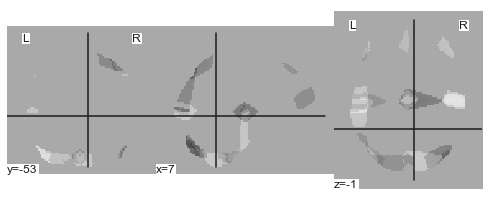

In [275]:
plotting.plot_anat(resampled_xai)

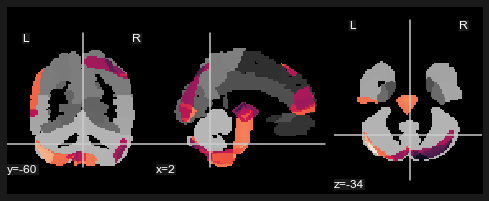

In [276]:
display = plotting.plot_anat(aal_array)
display.add_overlay(resampled_xai)

In [277]:
value_by_parts = {}
for label, index in zip(aal_labels, aal_indices):

    mask = aal_array.get_fdata() == int(index)
    num_voxels_roi = count_nonzero_voxels(mask)
    value = np.nansum(np.abs(resampled_xai.get_fdata()[mask])) / num_voxels_roi
    value_by_parts[label] = value

<AxesSubplot:title={'center':'Average GradCAM values on ATLAS'}>

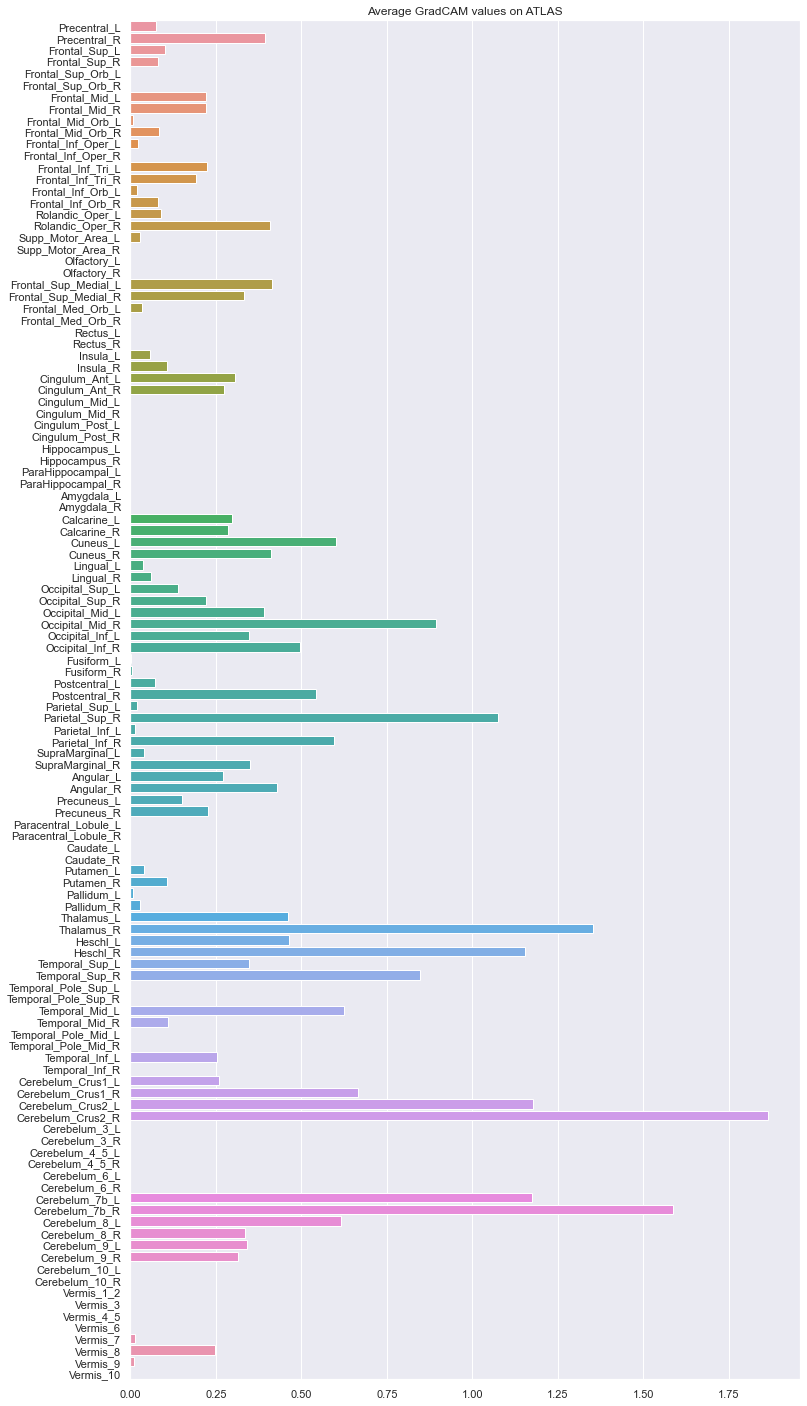

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(figsize=(12, 25))
ax.set_title("Average GradCAM values on ATLAS")
sns.barplot(
    x=list(value_by_parts.values()),
    y=list(value_by_parts.keys()),
    ax=ax
)

<AxesSubplot:title={'center':'Average GradCAM values on ATLAS'}>

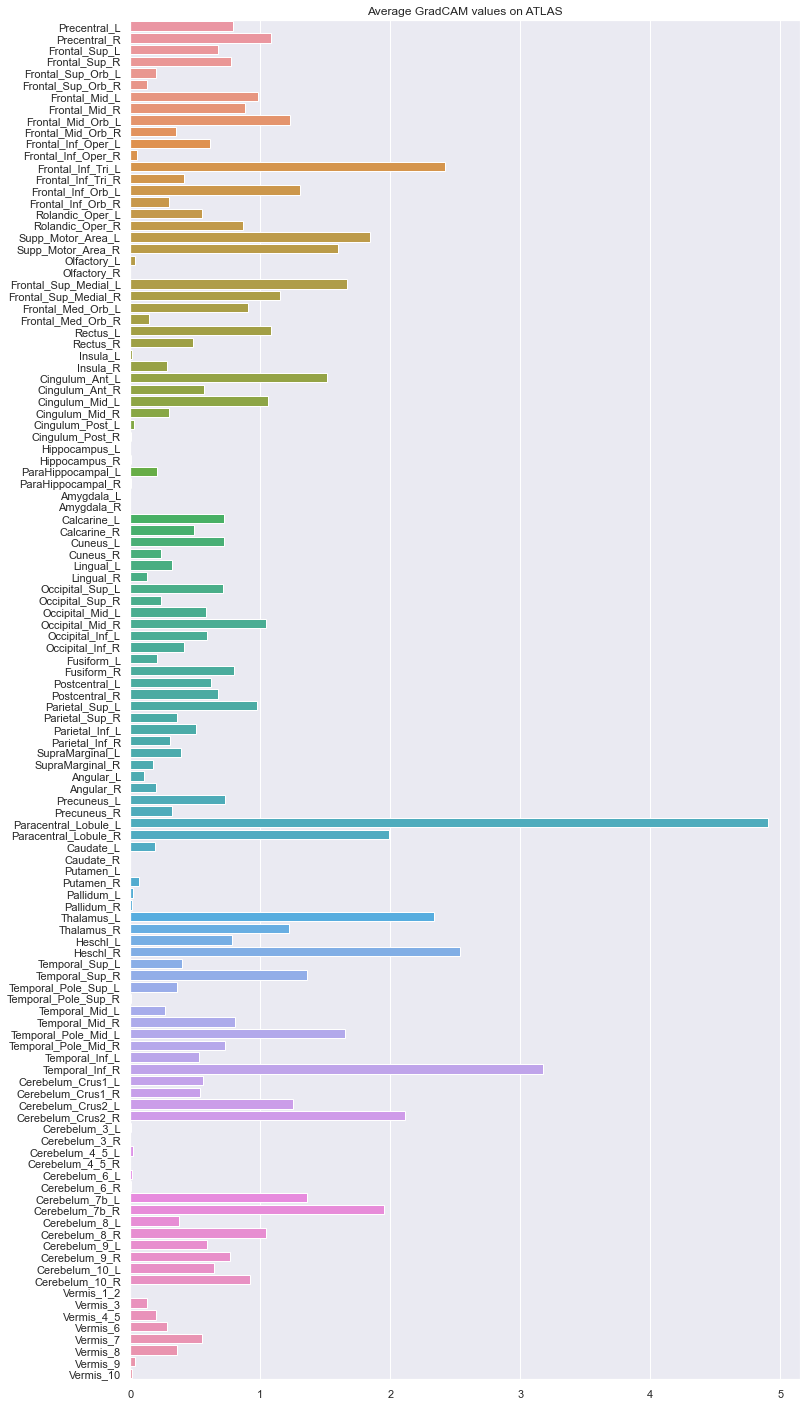

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(figsize=(12, 25))
ax.set_title("Average GradCAM values on ATLAS")
sns.barplot(
    x=list(value_by_parts.values()),
    y=list(value_by_parts.keys()),
    ax=ax
)

<AxesSubplot:title={'center':'Average GradCAM values on ATLAS'}>

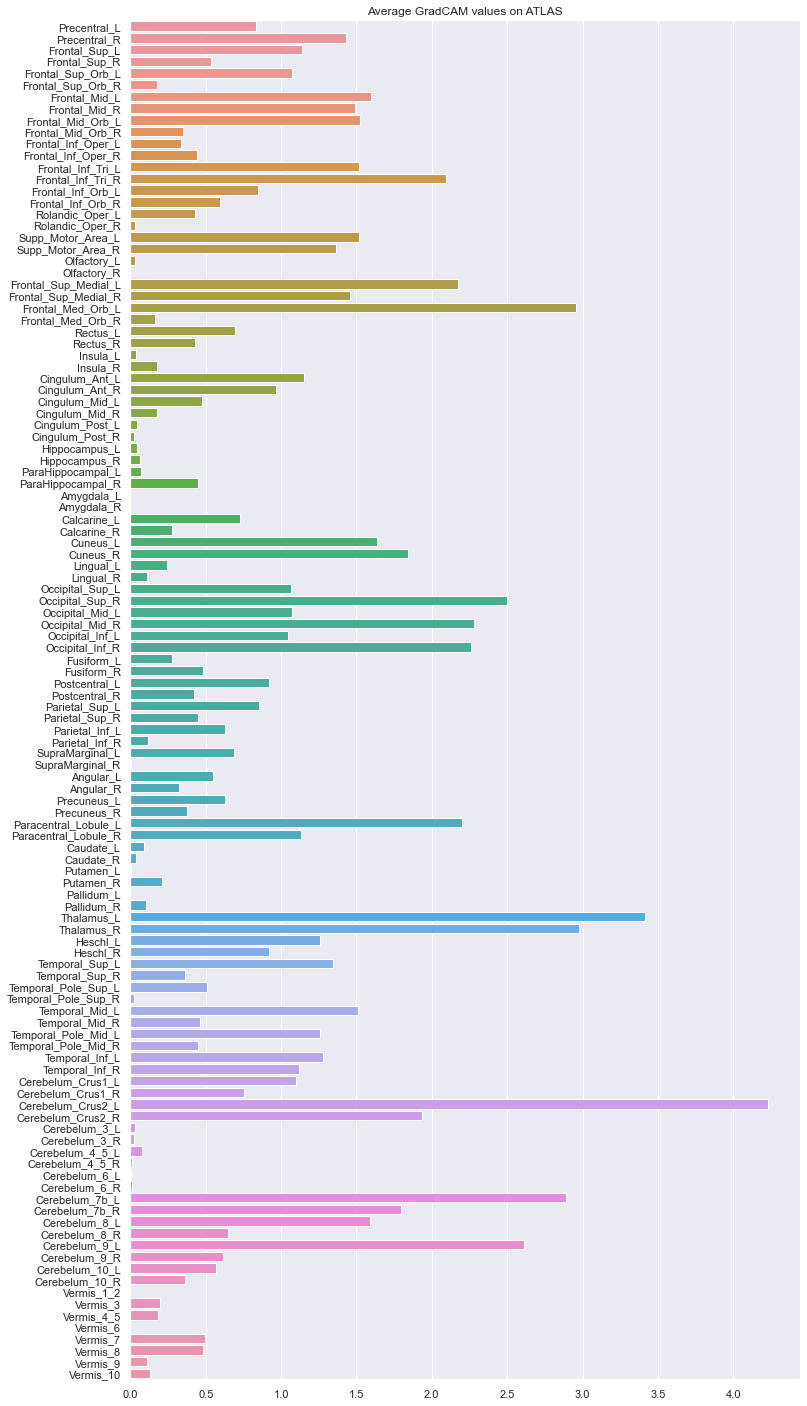

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(figsize=(12, 25))
ax.set_title("Average GradCAM values on ATLAS")
sns.barplot(
    x=list(value_by_parts.values()),
    y=list(value_by_parts.keys()),
    ax=ax
)